In [1]:
from neuron import h
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import h5py
import json
import os
from tqdm import tqdm

from cell_inference.config import paths, params
from cell_inference.cells.simulation import Simulation
from cell_inference.cells.stylizedcell import CellTypes
from cell_inference.utils.random_parameter_generator import Random_Parameter_Generator
from cell_inference.utils.transform.geometry_transformation import hphi2unitsphere, unitsphere2hphi, trivarnorm2unitsphere
from cell_inference.utils.transform.geometry_transformation import pol2cart, cart2pol
from cell_inference.utils.currents.ecp import EcpMod, EcpCell
from cell_inference.utils.plotting.plot_results import plot_lfp_traces, plot_lfp_heatmap
from cell_inference.utils.plotting.plot_morphology import plot_morphology
from cell_inference.utils.feature_extractors.SummaryStats2D import process_lfp, scaled_stats_indices
from cell_inference.utils.feature_extractors.parameterprediction import ClassifierTypes, ClassifierBuilder

## Load data

#### In vivo data

In [2]:
invivo_name = 'all_cell_LFP2D_Analysis_SensorimotorSpikeWaveforms_NP_SUTempFilter_NPExample'
# invivo_name = 'all_cell_LFP2D_Analysis_SensorimotorSpikes_NPUnits_large.h5'

INVIVO_PATH = 'cell_inference/resources/invivo'
INVIVO_LFP_PATH = os.path.join(INVIVO_PATH, 'lfp_' + invivo_name + '.npz')  # LFP and labels
INVIVO_STATS_PATH = os.path.join(INVIVO_PATH, 'summ_stats_' + invivo_name + '.npz')  # summary statistics

invivo_stats = np.load(INVIVO_STATS_PATH)['x']
layer = np.load(INVIVO_STATS_PATH)['layer']
y_c = np.load(INVIVO_STATS_PATH)['yc']

scaled_idx = scaled_stats_indices()

#### Simulation data

In [3]:
DATA_PATH = 'cell_inference/resources/simulation_data'
TRIAL_PATH = os.path.join(DATA_PATH, 'Reduced_Order_trunklength_Loc5_restrict_h') # select trial

STATS_PATH = os.path.join(TRIAL_PATH, 'summ_stats.npz')  # summary statistics
STATS = np.load(STATS_PATH)
summ_stats = STATS['x']
n_summ_stats = summ_stats.shape[1]

CONFIG_PATH = os.path.join(TRIAL_PATH, 'config.json')  # trial configuration
with open(CONFIG_PATH, 'r') as f:
    config_dict = json.load(f)

inference_list = config_dict['Trial_Parameters']['inference_list']
loc_param_list = config_dict['Simulation_Parameters']['loc_param_list']
ranges = config_dict['Simulation_Parameters']['loc_param_range']
ranges.update(config_dict['Simulation_Parameters']['geo_param_range'])

print(inference_list)

['y', 'd', 'theta', 'h', 'phi', 'l_t']


### Transform labels

#### Orientation

In [4]:
check_orient = 'h' in inference_list and 'phi' in inference_list
if check_orient:
    orient_idx0 = [inference_list.index(x) for x in ['h', 'phi']]
#     orient_idx2 = orient_idx0.copy()

direction_vec = True # represent orientation by vector on unit sphere
direction_vec = direction_vec and check_orient

label_list = inference_list.copy()
if direction_vec:
    orient_idx1 = list(range(len(inference_list) - 2, len(inference_list) + 1))
#     orient_idx2 = [orient_idx1[1], len(inference_list) + 1]
    label_list.remove('h')
    label_list.remove('phi')
    label_list += ['vx', 'vy', 'vz']
    for i in orient_idx1:
        ranges[label_list[i]] = [-1., 1.]

display_list = label_list.copy()
if direction_vec:
    display_list[orient_idx1[1]] = 'vy / h'
    display_list.append('phi')

#### y shift

In [5]:
has_yshift = 'y' in label_list
if has_yshift:
    ys_idx = label_list.index('y')
    label_list[ys_idx] = 'ys'
    display_list[display_list.index('y')] = 'y-shift'
    ranges['ys'] = [-150, 150] # set bound for normalization
    y_idx = loc_param_list.index('y')

#### Normalization

In [6]:
feature_range = (-1, 1)
norm_scale = lambda x, r: (x - r[0]) / (r[1] - r[0]) * (feature_range[1] - feature_range[0]) + feature_range[0]
org_scale = lambda x, r: (x - feature_range[0]) / (feature_range[1] - feature_range[0]) *  (r[1] - r[0]) + r[0]

### Get magnitude distribution

In [7]:
max_mag_idx = scaled_idx[[-4, -1]]
max_mag = np.amax(summ_stats[:, max_mag_idx], axis=1)
max_mag_invivo = np.amax(invivo_stats[:, max_mag_idx], axis=1)
mag_scale = np.mean(max_mag) / np.mean(max_mag_invivo)
invivo_stats_scaled = invivo_stats.copy()
invivo_stats_scaled[:, scaled_idx] *= mag_scale
print(mag_scale)

0.06921333769190983


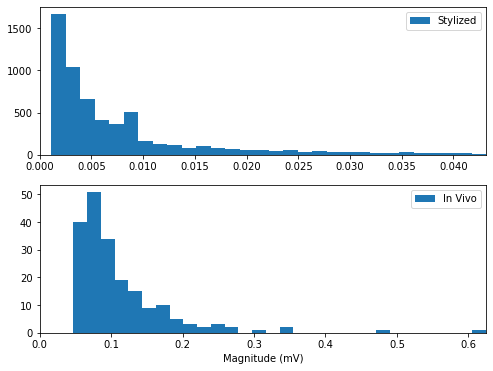

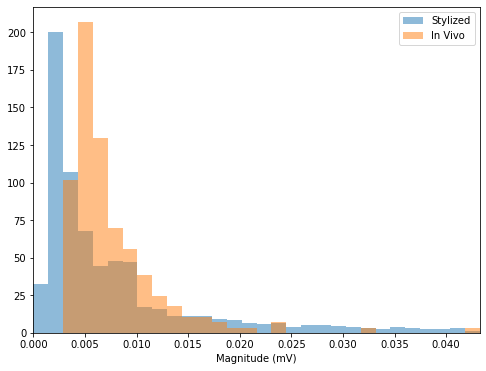

In [8]:
nbins = 30

plt.figure(figsize=(8, 6))
plt.subplot(211)
_, bins, _ = plt.hist(max_mag, bins=nbins, label='Stylized')
plt.xlim([0,bins[-1]])
plt.legend()
plt.subplot(212)
_, bins, _ = plt.hist(max_mag_invivo, bins=nbins, label='In Vivo')
plt.xlim([0,bins[-1]])
plt.legend()
plt.xlabel('Magnitude (uV)')

bins = np.linspace(0, max(np.amax(max_mag), np.amax(mag_scale * max_mag_invivo)), nbins + 1)
plt.figure(figsize=(8, 6))
plt.hist(max_mag, bins=bins, label='Stylized', density=True, alpha=0.5)
plt.hist(mag_scale * max_mag_invivo, bins=bins, label='In Vivo', density=True, alpha=0.5)
plt.xlim([0, bins[-1]])
plt.legend()
plt.xlabel('Magnitude (uV)')
plt.show()

## Load model

In [9]:
import torch
from cell_inference.utils.feature_extractors.fullyconnectednetwork import FullyConnectedNetwork, ActivationTypes
# from cell_inference.utils.feature_extractors.convolutionalnetwork import ConvolutionalNetwork

model_name = 'FCN_batch256' # select model
if direction_vec:
    model_name += '_dv'
model_name += '.pth'
MODEL_PATH = os.path.join(TRIAL_PATH, model_name)

model = FullyConnectedNetwork(in_features=n_summ_stats, out_features=len(label_list))
model.load_state_dict(torch.load(MODEL_PATH))
device = torch.device("cpu")
model.eval()

FullyConnectedNetwork(
  (hidden_layers): Sequential(
    (0): Linear(in_features=40, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=124, bias=True)
    (3): ReLU()
    (4): Linear(in_features=124, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): ReLU()
  )
  (output_layers): Linear(in_features=16, out_features=7, bias=True)
)

## Predict in vivo data

In [10]:
pred = model(torch.Tensor(invivo_stats_scaled).to(device)).to("cpu").detach().numpy()
for i, lb in enumerate(label_list):
    pred[:, i] = org_scale(pred[:, i], ranges[lb])
pred_list = label_list.copy()
pred_list = label_list.copy()
if has_yshift:
    pred[:, ys_idx] = y_c - pred[:, ys_idx]
    pred_list[pred_list.index('ys')] = 'y'
if direction_vec:
    pred[:, orient_idx1] = trivarnorm2unitsphere(pred[:, orient_idx1])
    pred = np.hstack([pred, unitsphere2hphi(pred[:, orient_idx1])[:, [1]]])
    pred_list[pred_list.index('vy')] = 'h'
    pred_list.append('phi')
pred_dict = dict(zip(pred_list, pred.T))
pred_dict['layer'] = layer

In [11]:
df_pred = pd.DataFrame(pred_dict).sort_values(by='y')

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_pred)

,y,d,theta,l_t,vx,h,vz,phi,layer
166,-1292.275879,272.982086,-1.143278,554.663879,0.461085,0.758944,-0.459787,2.354785,Layer6
125,-1232.504395,229.141861,-1.035875,631.286865,0.559339,0.705830,-0.434677,2.231433,Layer6
163,-1228.593384,209.024567,-1.119866,605.239624,0.560648,0.683599,-0.467297,2.265629,Layer6
11,-1224.635254,261.698975,-1.255054,563.293579,0.555387,0.685182,-0.471243,2.274416,Layer6
127,-1218.427490,274.364746,-0.922004,570.997375,0.478257,0.760755,-0.438773,2.313164,Layer6
168,-1213.875977,227.287750,-1.223858,576.843750,0.501205,0.716005,-0.485933,2.340724,Layer6
128,-1203.137939,278.988434,-1.068226,442.933289,0.444988,0.760989,-0.472103,2.385752,Layer6
4,-1195.239258,281.271118,-1.017579,490.378174,0.412055,0.775711,-0.478000,2.430151,Layer6
0,-1194.076904,258.244141,-0.809462,603.238708,0.412567,0.795133,-0.444467,2.393399,Layer6
171,-1188.558350,251.393646,-0.941946,680.262451,0.441979,0.757683,-0.480177,2.397593,Layer6


Text(0, 0.5, 'trunk_length')

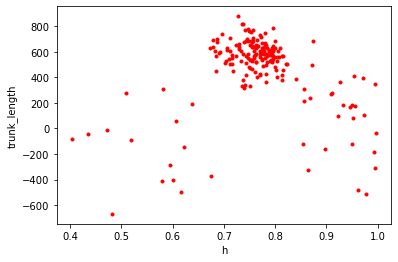

In [12]:
plt.figure()
plt.plot(pred_dict['h'], pred_dict['l_t'], 'r.')
plt.xlabel('h')
plt.ylabel('trunk_length')

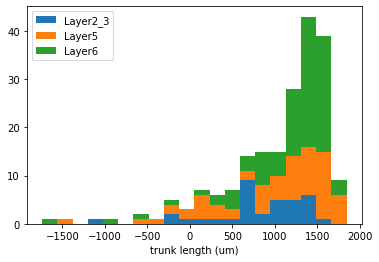

In [12]:
layer_type = np.unique(layer)
plt.figure()
plt.hist([pred_dict['l_t'][layer==ly] for ly in layer_type], bins=20, label=layer_type, stacked=True)
plt.xlabel('trunk length (um)')
plt.legend()
plt.show()

# Simulate with predicted parameters

In [21]:
def generate_predicted_parameters_from_config(config: dict, pred_dict: dict):
    tr_p = config['Trial_Parameters']
    tr_params = config['Simulation_Parameters']
    if 'n_sigma' not in tr_params.keys() or tr_params['n_sigma'] is None:
        n_sigma = 3.0
    else:
        n_sigma = tr_params['n_sigma']
    rpg = Random_Parameter_Generator(seed=tr_p['rand_seed'], n_sigma=n_sigma)
    
    # Location paramters
    loc_param_gen = tr_params['loc_param_list'].copy()
    polar_loc = 'd' in tr_p['randomized_list'] and 'theta' in tr_p['randomized_list']
    if polar_loc:
        loc_param_gen[loc_param_gen.index('x')] = 'd'
        loc_param_gen[loc_param_gen.index('z')] = 'theta'

    loc_param_samples = rpg.generate_parameters(tr_p['number_samples'], loc_param_gen,
                                                tr_p['randomized_list'], tr_params['loc_param_default'],
                                                tr_params['loc_param_range'], tr_params['loc_param_dist'])

    if polar_loc:
        loc_param_samples['x'], loc_param_samples['z'] = pol2cart(loc_param_samples['d'], loc_param_samples['theta'])

    loc_param = np.column_stack([loc_param_samples[key] for key in tr_params['loc_param_list']])

    # reshape into ncell-by-nloc-by-nparam
    loc_param = loc_param.reshape(tr_p['number_cells'], tr_p['number_locs'], -1)

    # Geometery parameters
    geo_param_samples = rpg.generate_parameters(tr_p['number_cells'], tr_params['geo_param_list'],
                                                tr_p['randomized_list'], tr_params['geo_param_default'],
                                                tr_params['geo_param_range'], tr_params['geo_param_dist'])

    geo_param = np.column_stack([geo_param_samples[key] for key in tr_params['geo_param_list']])

    # repeat to match number_samples
    for key, value in geo_param_samples.items():
        geo_param_samples[key] = np.repeat(value, tr_p['number_locs'])
    
    # Gather parameters as labels
    samples = {**geo_param_samples, **loc_param_samples}
    labels = np.column_stack([ samples[key] for key in tr_p['inference_list'] ])
    rand_param = np.column_stack([ samples[key] for key in tr_p['randomized_list'][:-len(tr_p['inference_list'])] ])
    return labels, rand_param, loc_param, geo_param


{'Trial_Parameters': {'number_cells': 500, 'number_locs': 12, 'number_samples': 6000, 'rand_seed': 12345, 'inference_list': ['y', 'd', 'theta', 'h', 'phi', 'l_t'], 'randomized_list': ['alpha', 'y', 'd', 'theta', 'h', 'phi', 'l_t']}, 'Simulation_Parameters': {'loc_param_list': ['x', 'y', 'z', 'alpha', 'h', 'phi'], 'geo_param_list': ['l_t'], 'loc_param_default': {'x': 0.0, 'y': 0.0, 'z': 50.0, 'alpha': 0.7853981633974483, 'h': 1.0, 'phi': 0.0, 'd': 50.0, 'theta': 0.0}, 'geo_param_default': {'l_t': 545.0}, 'loc_param_range': {'x': [-50, 50], 'y': [-1200, 1200], 'z': [50.0, 200.0], 'alpha': [0, 3.141592653589793], 'h': [0.7071, 1.0], 'phi': [-3.141592653589793, 3.141592653589793], 'd': [50.0, 200.0], 'theta': [-1.0471975511965976, 1.0471975511965976], 'l_t': [5.0, 595.0], 'vx': [-1.0, 1.0], 'vy': [-1.0, 1.0], 'vz': [-1.0, 1.0], 'ys': [-150, 150]}, 'geo_param_range': {'l_t': [5.0, 595.0]}, 'loc_param_dist': {'x': 'unif', 'y': 'unif', 'z': 'unif', 'alpha': 'unif', 'h': 'unif', 'phi': 'unif',

In [14]:
if config_dict['Simulation_Parameters']['gmax_mapping'] is None:
    gmax = config_dict['Simulation_Parameters']['gmax']

In [18]:
# Biophysical parameters
filepath = config_dict['Simulation_Parameters']['full_biophys']
with open(filepath) as f:
    full_biophys = json.load(f)

In [ ]:
case_name = ['detailed ground truth', 'stylized ground truth']
lfp = [detailed_lfp, stylized_lfp]
output = [process_lfp(x, ycoord=ycoord) for x in lfp]
loc_param_pred = len(lfp) * [loc_param_select]

for i in range(len(lfp)):
    out = output[i]
    if not out[0]:
        case_name.append('Predicted stylized from ' + case_name[i])
        # model output
        pred = model(torch.Tensor(out[6]).to(device)).to("cpu").detach().numpy()
        for i, lb in enumerate(label_list):
            pred[i] = org_scale(pred[i], ranges[lb])
        # transform
        pred_list = label_list.copy()
        if has_yshift:
            pred[ys_idx] = out[4] - pred[ys_idx]
            pred_list[pred_list.index('ys')] = 'y'
        if direction_vec:
            pred[orient_idx1] = trivarnorm2unitsphere(pred[orient_idx1])
            pred = np.hstack([pred, unitsphere2hphi(pred[orient_idx1])[:, 1]])
            pred_list[pred_list.index('vy')] = 'h'
            pred_list.append('phi')
        pred_dict = dict(zip(pred_list, pred))
        # get loc parameters
        if 'd' in pred_dict.keys() and 'theta' in pred_dict.keys():
            pred_dict['x'], pred_dict['z'] = pol2cart(pred_dict['d'], pred_dict['theta'])
        loc_param_pred.append(pred_dict)
        loc_pred = [pred_dict[x] if x in pred_dict.keys() else loc_param_select[x] for x in loc_param_list]
        # get lfp
        lfp.append(sim.lfp[0].calc_ecp(move_cell=loc_pred).T[start_idx:,:])
        output.append(process_lfp(lfp[-1], ycoord=ycoord))

In [13]:
# loc_param_select = {'y': 0., 'd': 80., 'theta': 0., 'alpha': np.pi*3/8, 'h': .85, 'phi': np.pi*3/5} # enter location parameters

# if 'd' in loc_param_select.keys() and 'theta' in loc_param_select.keys():
#     loc_param_select['x'], loc_param_select['z'] = pol2cart(loc_param_select['d'], loc_param_select['theta'])
# loc_param = np.array([loc_param_select[x] for x in loc_param_list])
# ycoord = loc_param[y_idx] if has_yshift else None

## Get ground truth

#### from detailed model

In [14]:
# if Initialize:
#     DETAILED_PATH = 'cell_inference/resources/detailed'
#     model_name = 'neuronal_model_491766131'
# #     file = os.path.join(DETAILED_PATH, model_name + '_Im.h5')
#     file = os.path.join(DETAILED_PATH, model_name + '_Im_strch.h5')

#     ecp_detailed = EcpMod(EcpCell(file=file), params.ELECTRODE_POSITION, move_cell=loc_param, min_distance = params.MIN_DISTANCE)

# detailed_lfp = ecp_detailed.calc_ecp(move_cell=loc_param).T

#### from stylized model

In [15]:
# if Initialize:
#     h.load_file('stdrun.hoc')
#     h.nrn_load_dll(paths.COMPILED_LIBRARY)
#     geo_standard = pd.read_csv(paths.GEO_STANDARD_OBLIQUE, index_col='id')
#     h.tstop = params.TSTOP
#     h.dt = params.DT

#     # Biophysical parameters
#     filepath = './cell_inference/resources/biophys_parameters/'+model_name+'.json'
#     with open(filepath) as f:
#         full_biophys = json.load(f)

#     # common parameters
#     biophys_param = [200, 50, 120] # Ra: basal, trunk, tuft
#     biophys_comm = {}

#     # geometry parameters
#     geo_param = [config_dict['Simulation_Parameters']['geo_param_default'][x] for x in config_dict['Simulation_Parameters']['geo_param_list']]

#     # Fixed gmax, not using gmax mapping file
#     gmax = 0.02

#     sim = Simulation(geometry = geo_standard,
#                      full_biophys = full_biophys,
#                      electrodes = params.ELECTRODE_POSITION,
#                      cell_type = CellTypes.ACTIVE_FULL,
#                      biophys = biophys_param,
#                      biophys_comm = biophys_comm,
#                      loc_param = loc_param,
#                      geo_param = geo_param,
#                      spike_threshold = params.SPIKE_THRESHOLD,
#                      gmax = gmax,
#                      stim_param = params.STIM_PARAM,
#                      min_distance = params.MIN_DISTANCE,
#                      ncell = 1)

#     sim.run_neuron_sim()
#     start_idx = int(np.ceil(params.STIM_PARAM['start']/h.dt)) # ignore signal before
#     Initialize = False

# stylized_lfp = sim.lfp[0].calc_ecp(move_cell=loc_param).T[start_idx:,:]

## Get prediction

In [16]:
# case_name = ['detailed ground truth', 'stylized ground truth']
# lfp = [detailed_lfp, stylized_lfp]
# output = [process_lfp(x, ycoord=ycoord) for x in lfp]
# loc_param_pred = len(lfp) * [loc_param_select]

# for i in range(len(lfp)):
#     out = output[i]
#     if not out[0]:
#         case_name.append('Predicted stylized from ' + case_name[i])
#         # model output
#         pred = model(torch.Tensor(out[6]).to(device)).to("cpu").detach().numpy()
#         for i, lb in enumerate(label_list):
#             pred[i] = org_scale(pred[i], ranges[lb])
#         # transform
#         pred_list = label_list.copy()
#         if has_yshift:
#             pred[ys_idx] = out[4] - pred[ys_idx]
#             pred_list[pred_list.index('ys')] = 'y'
#         if direction_vec:
#             pred[orient_idx1] = trivarnorm2unitsphere(pred[orient_idx1])
#             pred = np.hstack([pred, unitsphere2hphi(pred[orient_idx1])[:, 1]])
#             pred_list[pred_list.index('vy')] = 'h'
#             pred_list.append('phi')
#         pred_dict = dict(zip(pred_list, pred))
#         # get loc parameters
#         if 'd' in pred_dict.keys() and 'theta' in pred_dict.keys():
#             pred_dict['x'], pred_dict['z'] = pol2cart(pred_dict['d'], pred_dict['theta'])
#         loc_param_pred.append(pred_dict)
#         loc_pred = [pred_dict[x] if x in pred_dict.keys() else loc_param_select[x] for x in loc_param_list]
#         # get lfp
#         lfp.append(sim.lfp[0].calc_ecp(move_cell=loc_pred).T[start_idx:,:])
#         output.append(process_lfp(lfp[-1], ycoord=ycoord))

## Plot LFP

In [17]:
# %matplotlib inline

# ix = 1
# fontsize = 15
# labelpad = -10
# ticksize = 12
# tick_length = 5
# nbins = 5

# nlfp = len(lfp)
# plt.figure(figsize=(13, 4 * nlfp))
# for i, out in enumerate(output):
#     print("Case %d bad flag: %d" % (i, output[i][0]))
#     print(case_name[i])
#     print("Parameters: " + str(loc_param_pred[i]))
#     d = output[i][1]
#     t = output[i][2]
#     coords = output[i][3]
#     x_dist = np.unique(coords[:, 0])
#     e_idx = coords[:, 0]==x_dist[ix]

#     ax = plt.subplot(nlfp, 2, 2 * i + 1)
#     _ = plot_lfp_heatmap(t=t, elec_d=coords[e_idx, 1], lfp=d[:, e_idx],
#                          fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
#                          nbins=nbins, vlim='auto', axes = ax)
    
#     ax = plt.subplot(nlfp, 2, 2 * i + 2)
#     _ = plot_lfp_traces(t, d[:, e_idx], electrodes=coords[e_idx, :],
#                         fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
#                         nbins=nbins, axes = ax)
# plt.tight_layout(h_pad=0., w_pad=-0.5)
# plt.show()

## Plot morphology

In [18]:
# %matplotlib notebook

# _ = plot_morphology(sim, 0, electrodes=params.ELECTRODE_POSITION, move_cell=loc_param, elev=20, azim=-75, figsize=(10,8))